In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
##########
data1 = pd.read_csv('1st_simulation.csv', low_memory=False, header="infer")
row_index = data1[data1["tcp.srcport"] == 12345].index
if not row_index.empty:
    # Keep all rows starting from the found index
    data1 = data1.iloc[row_index[0]:]
#######
#data2
data2 = pd.read_csv('2nd_simulation.csv', low_memory=False, header="infer")
row_index = data2[data2["tcp.srcport"] == 12345].index
if not row_index.empty:
    # Keep all rows starting from the found index
    data2 = data2.iloc[row_index[0]:]
data = pd.concat([data1, data2], ignore_index=True)
data.reset_index(drop=True, inplace = True)
data[["tcp.flags.syn", "tcp.flags.ack", "tcp.flags.fin", "tcp.flags.rst"]] = data[["tcp.flags.syn", "tcp.flags.ack", "tcp.flags.fin", "tcp.flags.rst"]].astype(str)
data["tcp.flags.syn.bin"] = data["tcp.flags.syn"].map({"Set": 1, "Not set": 0})
data["tcp.flags.ack.bin"] = data["tcp.flags.ack"].map({"Set": 1, "Not set": 0})
data["tcp.flags.fin.bin"] = data["tcp.flags.fin"].map({"Set": 1, "Not set": 0})
data["tcp.flags.rst.bin"] = data["tcp.flags.rst"].map({"Set": 1, "Not set": 0})
data = data[data['Protocol'] == 'TCP']
########
# Create a logical vector indicating whether each column is numeric
is_numeric = data.dtypes.apply(lambda x: pd.api.types.is_numeric_dtype(x))
#tcp.checksum is removed even if it shouldn't be
# Drop columns that are not numeric
df_filtered = data.loc[:, is_numeric]
df_filtered.reset_index(drop=True, inplace = True)
df_filtered.info()
# description of the statistics
df_filtered.describe()
#########
#dataset labelling
attack_list = []
for i in range(len(df_filtered["No."])):
    if (308190)<= i<=(601436):
        if df_filtered["tcp.srcport"][i] == 12345 and df_filtered["tcp.srcport"][i] == 12345:
            attack_list.append(0)
        else:
            attack_list.append(1)
    elif (1348065)<= i<=(1751525):
        if df_filtered["tcp.srcport"][i] == 12345 and df_filtered["tcp.srcport"][i] == 12345:
            attack_list.append(0)
        else:
            attack_list.append(1)
    else: 
        attack_list.append(0)
print(f"Proportion of normal and attack traffic: {sum(attack_list)/len(attack_list)}")
#########
np.random.seed(42)
DF_dec_tree = df_filtered.drop(["No.", "Time", "tcp.srcport", "tcp.dstport"], axis = 1)
DF_dec_tree.info()

X_class = DF_dec_tree.values
# differential privacy cell
sensitivities = {
    DF_dec_tree.columns.get_loc('tcp.ack'): np.ptp(df_filtered['tcp.ack']),
    DF_dec_tree.columns.get_loc('tcp.seq'): np.ptp(df_filtered['tcp.seq']),
    DF_dec_tree.columns.get_loc('tcp.stream'): np.ptp(df_filtered['tcp.stream']),
    DF_dec_tree.columns.get_loc('tcp.window_size_value'): np.ptp(df_filtered['tcp.window_size_value']),
    DF_dec_tree.columns.get_loc('tcp.time_delta'): np.ptp(df_filtered['tcp.time_delta']),
    DF_dec_tree.columns.get_loc('tcp.len'): np.ptp(df_filtered['tcp.len']),
    DF_dec_tree.columns.get_loc('Length'): np.ptp(df_filtered['Length'])
}
#########

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_class, attack_list, test_size=0.4, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014523 entries, 0 to 2014522
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   No.                    int64  
 1   Time                   float64
 2   Length                 int64  
 3   tcp.ack                int64  
 4   tcp.len                float64
 5   tcp.window_size_value  int64  
 6   tcp.stream             int64  
 7   tcp.time_delta         float64
 8   tcp.seq                int64  
 9   tcp.srcport            int64  
 10  tcp.dstport            int64  
 11  tcp.flags.syn.bin      int64  
 12  tcp.flags.ack.bin      int64  
 13  tcp.flags.fin.bin      int64  
 14  tcp.flags.rst.bin      int64  
dtypes: float64(3), int64(12)
memory usage: 230.5 MB
Proportion of normal and attack traffic: 0.33828603594994944
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014523 entries, 0 to 2014522
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------ 

In [3]:
print(sensitivities)

{1: 1862037, 6: 1861950, 4: 191425, 3: 65535, 5: 10.178403, 2: 16332.0, 0: 16344}


In [4]:
# DEFINITION OF PRIVACY BUDGET
epsilon = 0.01
X_train_noisy = X_train.copy()
X_test_noisy = X_test.copy()
for feature, sensitivity in sensitivities.items():
    print("The scale for", feature, "is", sensitivity/epsilon)
    # Apply Laplace noise
    row1, column1 = X_train_noisy.shape
    X_train_noisy[:,feature] = X_train_noisy[:,feature] + np.random.laplace(loc=0, scale=(sensitivity/epsilon), size = row1)
    row2, c = X_test_noisy.shape
    X_test_noisy[:,feature] = X_test_noisy[:,feature] + np.random.laplace(loc=0, scale=(sensitivity/epsilon), size = row2)

classifier = DecisionTreeClassifier(random_state=2, max_depth=5) #adjusting depth changes accuracy and other metrics when changing noise
classifier.fit(X_train_noisy, y_train)

# Make predictions
y_pred = classifier.predict(X_test_noisy)

# Evaluate the model
print(classification_report(y_test, y_pred))

The scale for 1 is 186203700.0
The scale for 6 is 186195000.0
The scale for 4 is 19142500.0
The scale for 3 is 6553500.0
The scale for 5 is 1017.8403
The scale for 2 is 1633200.0
The scale for 0 is 1634400.0
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    533073
           1       0.99      0.49      0.65    272737

    accuracy                           0.83    805810
   macro avg       0.89      0.74      0.77    805810
weighted avg       0.86      0.83      0.81    805810



In [5]:
from sklearn.metrics import accuracy_score
performance = {"Epsilon": [], "Accuracy": []}

for epsilon in range(1,11):
    X_train_noisy = X_train.copy()
    X_test_noisy = X_test.copy()
    for feature, sensitivity in sensitivities.items():
        #print("The scale for", feature, "is", sensitivity/epsilon)
        # Apply Laplace noise
        row1, column1 = X_train_noisy.shape
        X_train_noisy[:,feature] = X_train_noisy[:,feature] + np.random.laplace(loc=0, scale=(sensitivity/epsilon), size = row1)
        row2, c = X_test_noisy.shape
        X_test_noisy[:,feature] = X_test_noisy[:,feature] + np.random.laplace(loc=0, scale=(sensitivity/epsilon), size = row2)

    classifier = DecisionTreeClassifier(random_state=2, max_depth=5)
    classifier.fit(X_train_noisy, y_train)

    # Make predictions
    y_pred = classifier.predict(X_test_noisy)
    print(f"CURRENT EPSILON: {epsilon}")
    # Evaluate the model
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    performance["Epsilon"].append(epsilon)
    performance["Accuracy"].append(accuracy)

CURRENT EPSILON: 1
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    533073
           1       0.99      0.49      0.65    272737

    accuracy                           0.83    805810
   macro avg       0.89      0.74      0.77    805810
weighted avg       0.86      0.83      0.81    805810

CURRENT EPSILON: 2
              precision    recall  f1-score   support

           0       0.83      0.95      0.89    533073
           1       0.87      0.62      0.72    272737

    accuracy                           0.84    805810
   macro avg       0.85      0.79      0.81    805810
weighted avg       0.84      0.84      0.83    805810

CURRENT EPSILON: 3
              precision    recall  f1-score   support

           0       0.88      0.91      0.90    533073
           1       0.81      0.77      0.79    272737

    accuracy                           0.86    805810
   macro avg       0.85      0.84      0.84    805810
weighted avg     

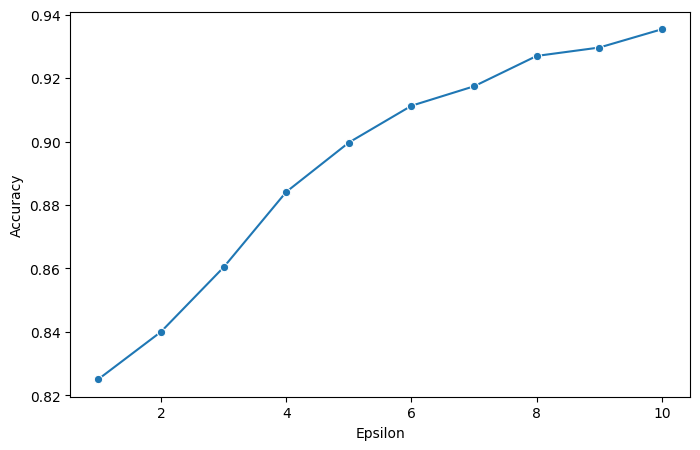

In [6]:
import seaborn as sns
performance = pd.DataFrame(performance)
plt.figure(figsize=(8, 5))
sns.lineplot(x='Epsilon', y='Accuracy', data=performance, marker='o')

# Add labels and title
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

# Show plot
plt.show()

In [7]:
from sklearn.metrics import accuracy_score
performance2 = {"Epsilon": [], "Accuracy": []}

for epsilon in range(1,11):
    X_train_noisy = X_train.copy()
    X_test_noisy = X_test.copy()
    for feature, sensitivity in sensitivities.items():
        #print("The scale for", feature, "is", sensitivity/epsilon)
        # Apply Laplace noise
        row1, column1 = X_train_noisy.shape
        X_train_noisy[:,feature] = X_train_noisy[:,feature] + np.random.laplace(loc=0, scale=(sensitivity/epsilon), size = row1)
        row2, c = X_test_noisy.shape
        X_test_noisy[:,feature] = X_test_noisy[:,feature] + np.random.laplace(loc=0, scale=(sensitivity/epsilon), size = row2)

    classifier = DecisionTreeClassifier(random_state=2, max_depth=10)
    classifier.fit(X_train_noisy, y_train)

    # Make predictions
    y_pred = classifier.predict(X_test_noisy)
    print(f"CURRENT EPSILON: {epsilon}")
    # Evaluate the model
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    performance2["Epsilon"].append(epsilon)
    performance2["Accuracy"].append(accuracy)

CURRENT EPSILON: 1
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    533073
           1       0.98      0.49      0.65    272737

    accuracy                           0.82    805810
   macro avg       0.89      0.74      0.77    805810
weighted avg       0.86      0.82      0.81    805810

CURRENT EPSILON: 2
              precision    recall  f1-score   support

           0       0.84      0.95      0.89    533073
           1       0.86      0.64      0.73    272737

    accuracy                           0.84    805810
   macro avg       0.85      0.79      0.81    805810
weighted avg       0.84      0.84      0.84    805810

CURRENT EPSILON: 3
              precision    recall  f1-score   support

           0       0.88      0.93      0.90    533073
           1       0.85      0.74      0.79    272737

    accuracy                           0.87    805810
   macro avg       0.86      0.84      0.85    805810
weighted avg     

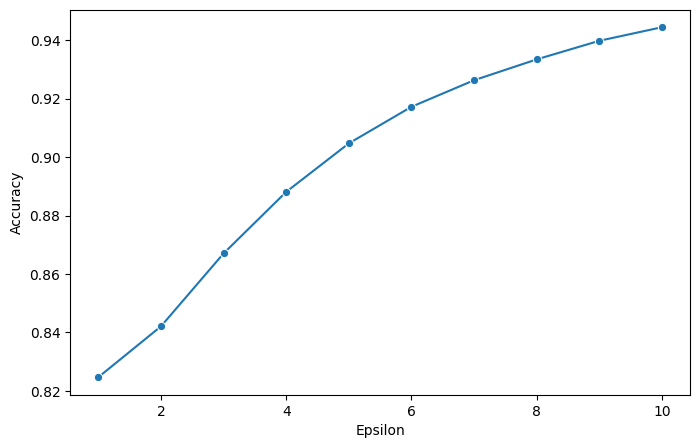

In [8]:
import seaborn as sns
performance2 = pd.DataFrame(performance2)
plt.figure(figsize=(8, 5))
sns.lineplot(x='Epsilon', y='Accuracy', data=performance2, marker='o')

# Add labels and title
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

# Show plot
plt.show()

In [9]:
performance3 = {"Epsilon": [], "Accuracy": []}

for epsilon in range(1,11):
    X_train_noisy = X_train.copy()
    X_test_noisy = X_test.copy()
    for feature, sensitivity in sensitivities.items():
        #print("The scale for", feature, "is", sensitivity/epsilon)
        # Apply Laplace noise
        row1, column1 = X_train_noisy.shape
        X_train_noisy[:,feature] = X_train_noisy[:,feature] + np.random.laplace(loc=0, scale=(sensitivity/epsilon), size = row1)
        row2, c = X_test_noisy.shape
        X_test_noisy[:,feature] = X_test_noisy[:,feature] + np.random.laplace(loc=0, scale=(sensitivity/epsilon), size = row2)

    classifier = DecisionTreeClassifier(random_state=2, max_depth=3)
    classifier.fit(X_train_noisy, y_train)

    # Make predictions
    y_pred = classifier.predict(X_test_noisy)
    print(f"CURRENT EPSILON: {epsilon}")
    # Evaluate the model
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    performance3["Epsilon"].append(epsilon)
    performance3["Accuracy"].append(accuracy)

CURRENT EPSILON: 1
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    533073
           1       0.99      0.49      0.65    272737

    accuracy                           0.83    805810
   macro avg       0.89      0.74      0.77    805810
weighted avg       0.86      0.83      0.81    805810

CURRENT EPSILON: 2
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    533073
           1       0.99      0.49      0.65    272737

    accuracy                           0.83    805810
   macro avg       0.89      0.74      0.77    805810
weighted avg       0.86      0.83      0.81    805810

CURRENT EPSILON: 3
              precision    recall  f1-score   support

           0       0.86      0.93      0.89    533073
           1       0.84      0.71      0.77    272737

    accuracy                           0.85    805810
   macro avg       0.85      0.82      0.83    805810
weighted avg     

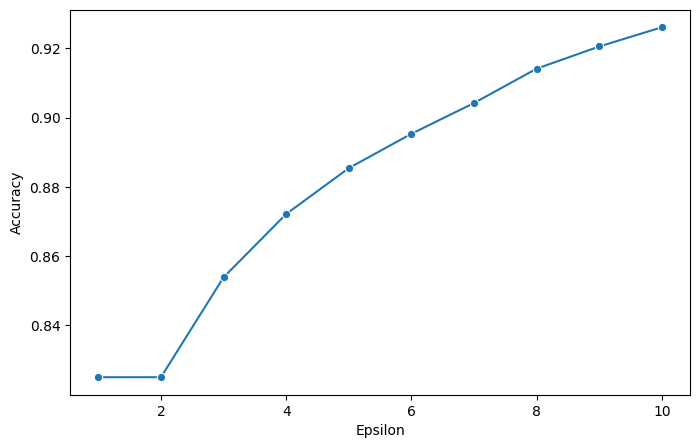

In [10]:
import seaborn as sns
performance3 = pd.DataFrame(performance3)
plt.figure(figsize=(8, 5))
sns.lineplot(x='Epsilon', y='Accuracy', data=performance3, marker='o')

# Add labels and title
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

# Show plot
plt.show()

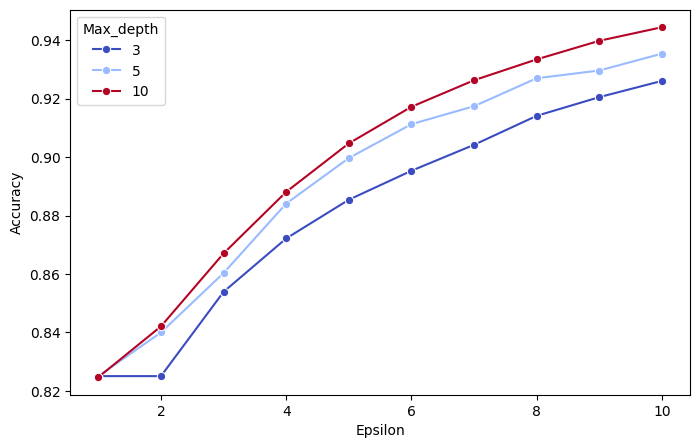

In [11]:
performances = pd.concat([performance, performance2, performance3])
performances["Max_depth"] = [5]*10 + [10]*10 + [3]*10
plt.figure(figsize=(8, 5))
sns.lineplot(x='Epsilon', y='Accuracy', hue = "Max_depth", data=performances, marker='o', palette="coolwarm")

# Add labels and title
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

# Show plot
plt.show()